In [1]:
from lofarimaging import *

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker
import matplotlib.artist
from datetime import datetime
import numpy as np
from datetime import datetime
import h5py

In [3]:
from tqdm.autonotebook import tqdm

/anaconda/envs/school19/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
h5 = h5py.File("results/results.h5", "r")

## Overview plot with times a pixel is the brightest

In [6]:
def pixelcoord_to_m_coord(pixel_coord, shape, extent):
    """Convert pixel coordinate (y, x) to coordinates in metres x, y"""
    (y, x) = pixel_coord
    x_0, x_1, y_0, y_1 = extent
    x_m = x_0 + (x / shape[1]) * (x_1 - x_0)
    y_m = y_0 + (y / shape[1]) * (y_1 - y_0)
    return x_m, y_m

In [7]:
# These coordinates were picked as the maximum pixel in some observations that show RFI. See section below.
hot_coords = {}
hot_coords["RS210"] = (1,113)
hot_coords["CS103"] = (241, 150)
hot_coords["RS208"] = (59, 121)

In [8]:
dateformatter_with_date = mdates.DateFormatter("%Y-%m-%d %H:%M")
dateformatter_without_date = mdates.DateFormatter("%H:%M")

def format_date(x, pos=None):
    if x % 1 in (0, 0.5):
        return dateformatter_with_date.format_data(x)
    else:
        return dateformatter_without_date.format_data(x)

In [9]:
station_name = "RS208"

obstimes = {}
coefs = {}

In [10]:
subband = 150

In [11]:
for subband in tqdm([150, 250, 350, 375, 400, 425]):
    all_obsnums = get_obsnums(h5, station_name=station_name, subband=subband, rcu_modes=[1,2],
                              extent=[-300,300,-300,300])

    obstimes[subband] = []
    coefs[subband] = []
    for obs in tqdm(all_obsnums, leave=False):
        data = h5[obs]["ground_images"]["ground_img000"].value
        obstime = datetime.strptime(h5[obs].attrs["obstime"], "%Y-%m-%d %H:%M:%S")
        coef = (data[hot_coords[station_name]] - np.min(data)) / (np.max(data) - np.min(data))
        obstimes[subband].append(obstime)
        coefs[subband].append(coef)

/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


/anaconda/envs/school19/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


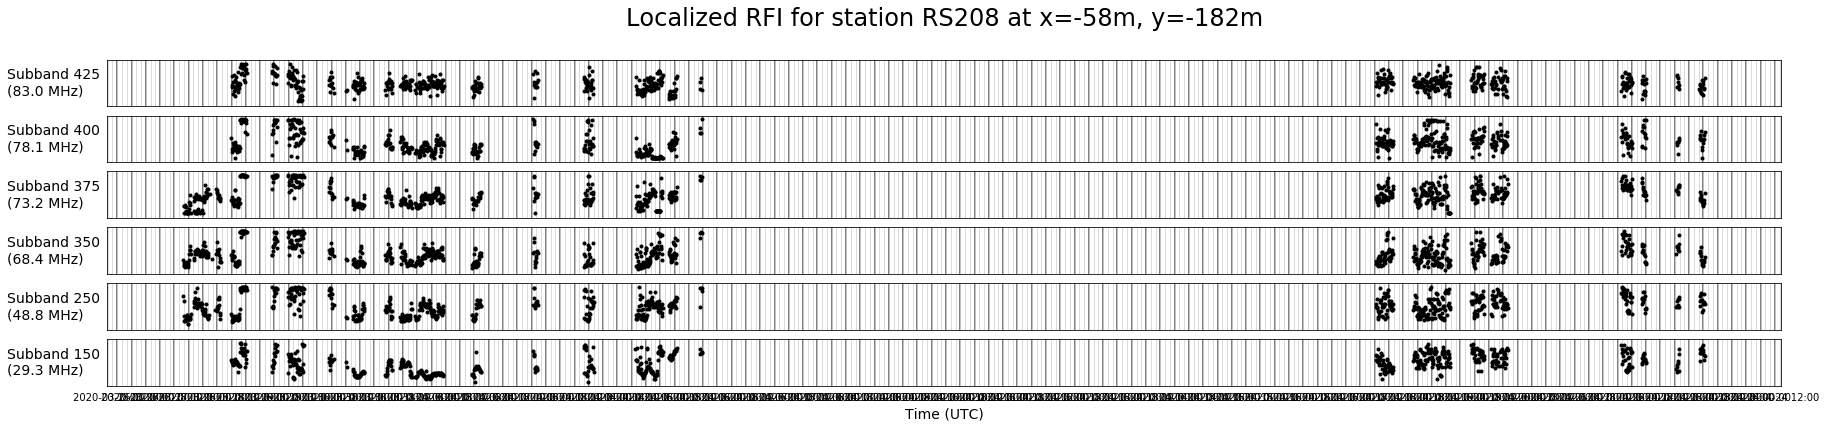

In [20]:
coords = pixelcoord_to_m_coord(hot_coords[station_name], (300, 300), [-300, 300, -300, 300])
fig, axes = plt.subplots(nrows=len(coefs), figsize=(30, len(coefs)), sharex=True)
axes[0].set_title(f"Localized RFI for station {station_name} at x={coords[0]:.0f}m, y={coords[1]:.0f}m\n", size=24)
for subbandnr, subband in enumerate(reversed(sorted(coefs))):
    axes[subbandnr].plot(obstimes[subband], coefs[subband], 'k.')
    axes[subbandnr].set_ylim(-.1, 1.1);
    freq = freq_from_sb(subband, 1)
    axes[subbandnr].set_ylabel(f"Subband {subband}\n({freq/1e6:.1f} MHz)", rotation=0, size=14, labelpad=100, horizontalalignment="left",
                              verticalalignment="center")
    axes[subbandnr].set_yticks([])
    axes[subbandnr].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(format_date))
    axes[subbandnr].xaxis.set_ticks_position('none')
    axes[subbandnr].xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))
    axes[subbandnr].xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    axes[subbandnr].grid(color='gray', which='major', linewidth=2)
    axes[subbandnr].grid(color='lightgray', which='minor')
axes[subbandnr].set_xlabel("Time (UTC)", size=14)
fig.patch.set_facecolor('white')

## Quick look

Find any observation which shows the RFI:

In [12]:
from ipywidgets import interact

In [51]:
station_name = "CS103"
subband = 375

In [52]:
all_obsnums = get_obsnums(h5, station_name=station_name, subband=subband,
                          extent=[-300, 300, -300, 300])

In [55]:
def plot_obs(obs_idx):
    obs = all_obsnums[obs_idx]
    ground_img = h5[obs]["ground_images"]["ground_img000"]
    data = ground_img.value
    plt.imshow(ground_img.value, origin='lower')#, vmin=9.5e5, vmax=11.8e5)
    plt.colorbar()
    maxpos = np.unravel_index(np.argmax(data), data.shape)
    plt.title(f"{obs}: {maxpos}")
    plt.show();

In [57]:
interact(plot_obs, obs_idx=(0, len(all_obsnums)-1));

interactive(children=(IntSlider(value=421, description='obs_idx', max=842), Output()), _dom_classes=('widget-i…

## Make movie

In [58]:
import matplotlib.animation as animation

In [59]:
station_name = "CS103"

In [60]:
subband = 375

In [61]:
rcu_modes = [1, 2]

In [63]:
all_obsnums = get_obsnums(h5, station_name=station_name, subband=subband, rcu_modes=rcu_modes, extent=[-300, 300, -300, 300])

In [65]:
obsnum = all_obsnums[0]

In [66]:
obs_h5 = h5[obsnum]
grounddata_h5 = obs_h5["ground_images"]["ground_img000"]
extent = grounddata_h5.attrs["extent"]
extent_lonlat = grounddata_h5.attrs["extent_lonlat"]
skydata_h5 = obs_h5["sky_img"]

In [67]:
subband = obs_h5.attrs["subband"]
freq = obs_h5.attrs["frequency"]
obstime = obs_h5.attrs["obstime"]

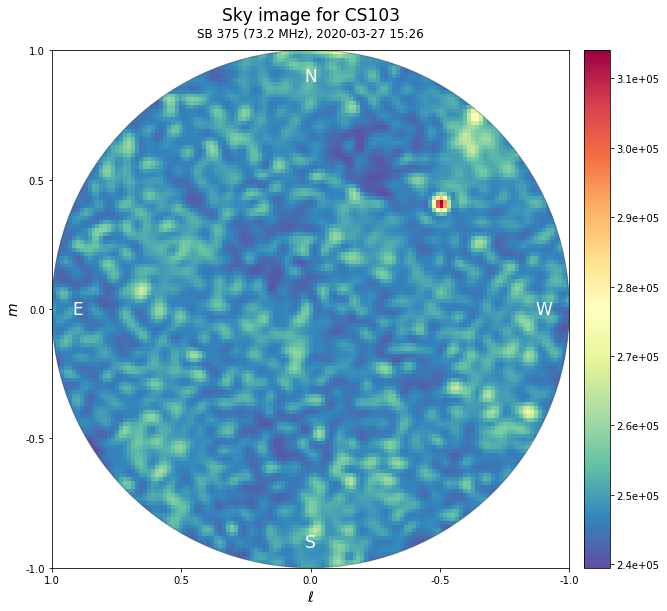

In [70]:
sky_fig = make_sky_plot(skydata_h5.value, {}, title=f"Sky image for {station_name}", subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}");

In [73]:
t = tqdm(total=len(all_obsnums))

def update_img(frame_nr):
    im = sky_fig.get_children()[1].images[0]
    obs_h5 = h5[all_obsnums[frame_nr]]
    skydata_h5 = obs_h5["sky_img"]
    obstime = obs_h5.attrs["obstime"]
    im.set_data(skydata_h5.value)
    im.set_clim(np.min(skydata_h5.value), np.max(skydata_h5.value))
    subtitle = [child for child in sky_fig.get_children()[1].get_children()
                if isinstance(child, matplotlib.text.Text) and "SB " in child.get_text()][0]
    subtitle.set_text(f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}")
    t.update()

ani = animation.FuncAnimation (sky_fig, update_img, len(all_obsnums), interval=30, blit=False)
writer = animation.writers['ffmpeg'](fps=10, bitrate=800)

ani.save(f'sky_movie_{station_name}_SB{subband}.mp4', writer=writer, dpi=sky_fig.dpi)
t.close()

In [75]:
background_map = get_map(*extent_lonlat)

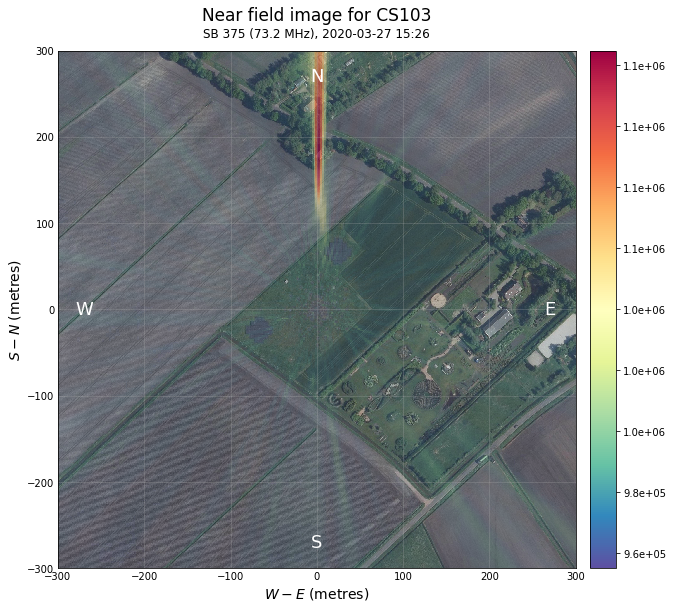

In [76]:
ground_fig, data = make_ground_plot(grounddata_h5.value, background_map, extent, title=f"Near field image for {station_name}",
                                    subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}", draw_contours=False)

t = tqdm(total=len(all_obsnums)) # Initialise

def update_img(frame_nr):
    im = ground_fig.get_children()[1].images[1]
    obs_h5 = h5[all_obsnums[frame_nr]]
    grounddata_h5 = obs_h5["ground_images"]["ground_img000"]
    obstime = obs_h5.attrs["obstime"]
    im.set_data(grounddata_h5.value)
    im.set_clim(np.min(grounddata_h5.value), np.max(grounddata_h5.value))
    subtitle = [child for child in ground_fig.get_children()[1].get_children()
                if isinstance(child, matplotlib.text.Text) and "SB " in child.get_text()][0]
    subtitle.set_text(f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}")
    t.update()
    return im

ani = animation.FuncAnimation (ground_fig, update_img, len(all_obsnums), interval=30)
writer = animation.writers['ffmpeg'](fps=10, bitrate=500)
ani.save(f'nearfield_movie_{station_name}.mp4', writer=writer, dpi=ground_fig.dpi)
t.close()

## Find one timeslot

In [77]:
from ipywidgets import interact

In [80]:
all_obsnums = get_obsnums(h5, start_date=datetime(2020, 4, 4, 21, 43), end_date=datetime(2020, 4, 4, 21, 46))

In [85]:
all_obsnums

['obs008079', 'obs008080', 'obs008081', 'obs008082', 'obs008083', 'obs008084']

In [86]:
from astropy.coordinates import SkyCoord, get_sun, EarthLocation, GCRS, AltAz
import astropy.units as u
from astropy.time import Time

In [87]:
from lofarantpos.db import LofarAntennaDatabase

In [88]:
db = LofarAntennaDatabase()

In [89]:
obstime_astropy = Time(h5["obs008081"].attrs['obstime'])

In [90]:
station_earthlocation = EarthLocation.from_geocentric(*(db.phase_centres["RS210LBA"] * u.m))

In [91]:
zenith = AltAz(az=0 * u.deg, alt=90 * u.deg, obstime=obstime_astropy,
                   location=station_earthlocation).transform_to(GCRS)

In [92]:
marked_bodies = {
    'Cas A': SkyCoord(ra=350.85 * u.deg, dec=58.815 * u.deg),
    'Cyg A': SkyCoord(ra=299.868 * u.deg, dec=40.734 * u.deg),
    #        'Per A': SkyCoord.from_name("Perseus A"),
    #        'Her A': SkyCoord.from_name("Hercules A"),
    #        'Cen A': SkyCoord.from_name("Centaurus A"),
    #        '?': SkyCoord.from_name("J101415.9+105106"),
    #        '3C295': SkyCoord.from_name("3C295"),
    #        'Moon': get_moon(obstime_astropy, location=station_earthlocation).transform_to(GCRS),
    'Sun': get_sun(obstime_astropy)
    #        '3C196': SkyCoord.from_name("3C196")
}
marked_bodies_lmn = {}

In [93]:
for body_name, body_coord in marked_bodies.items():
    # print(body_name, body_coord.separation(zenith), body_coord.separation(zenith))
    if body_coord.transform_to(AltAz(location=station_earthlocation, obstime=obstime_astropy)).alt > 0:
        marked_bodies_lmn[body_name] = skycoord_to_lmn(marked_bodies[body_name], zenith)

In [94]:
def make_plot(num):
    return make_sky_plot(h5[num]["sky_img"].value, marked_bodies_lmn, vmin=2.3e5, vmax=2.6e5);

In [95]:
interact(make_plot, num=[f"obs008{num:03d}" for num in list(range(81-3*18, 81+3*18, 18))]);

interactive(children=(Dropdown(description='num', options=('obs008027', 'obs008045', 'obs008063', 'obs008081',…

In [96]:
h5.close()

## Re-image at different resolution

In [97]:
h5 = h5py.File("results/oneobs.h5", "r")

In [98]:
station_name = "RS208"

In [99]:
subband = 425

In [100]:
rcu_modes = [1, 2]

In [101]:
start_time = datetime.strptime("2020-04-23 18:15:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime("2020-04-23 18:16:00", "%Y-%m-%d %H:%M:%S")

In [102]:
all_obsnums = get_obsnums(h5, station_name=station_name, subband=subband, start_date=start_time, end_date=end_time)

In [107]:
obsnum = all_obsnums[0]

In [108]:
from lofarantpos.db import LofarAntennaDatabase
db = LofarAntennaDatabase()

In [109]:
visibilities = h5[obsnum]['calibrated_data'].value
visibilities_xx = visibilities[0::2, 0::2]
visibilities_yy = visibilities[1::2, 1::2]
# Stokes I
visibilities_stokesI = visibilities_xx + visibilities_yy
baseline_indices = np.tril_indices(visibilities_stokesI.shape[0])
visibilities_selection = visibilities_stokesI[baseline_indices]

In [110]:
get_full_station_name(station_name, h5[obsnum].attrs['rcu_mode'])

'RS208LBA'

In [147]:
extent = [0, 2600, -1700, 0]

In [148]:
extent_lonlat = get_extent_lonlat(extent, get_full_station_name(station_name, h5[obsnum].attrs['rcu_mode']), db)

In [149]:
ground_img = nearfield_imager(visibilities_selection.flatten()[:, np.newaxis],
                              np.array(baseline_indices).T, [h5[obsnum].attrs['frequency']],
                              600, 600, extent,
                              get_station_pqr(h5[obsnum].attrs["station_name"], h5[obsnum].attrs["rcu_mode"], db))
ground_img = np.real(2 * ground_img)

In [150]:
background_map = get_map(*extent_lonlat, 14)

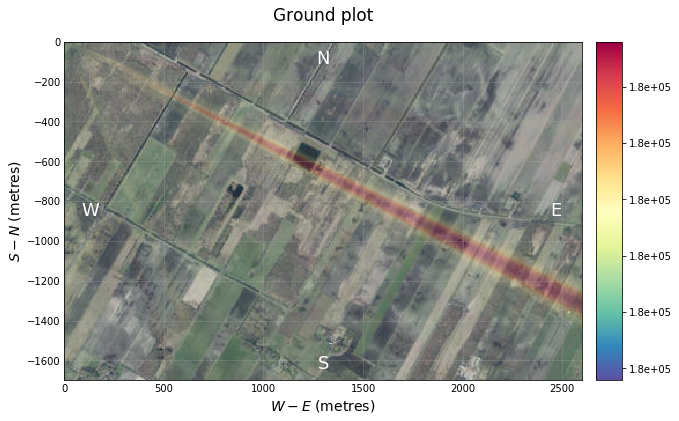

In [153]:
fig, folium_overlay = make_ground_plot(ground_img, background_map, extent, draw_contours=False, opacity=0.3)

In [157]:
extent_lonlat

[6.918977013608436, 6.957410332847523, 52.65404974728106, 52.66932017669215]

In [159]:
extent_lonlat

[6.918977013608436, 6.957410332847523, 52.65404974728106, 52.66932017669215]

In [160]:
make_leaflet_map(folium_overlay, *(extent_lonlat[1:3]), extent_lonlat[0], extent_lonlat[2], extent_lonlat[1], extent_lonlat[3])